In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from bettermdptools.algorithms.planner import Planner
from bettermdptools.algorithms.rl import RL
from bettermdptools.utils.blackjack_wrapper import BlackjackWrapper
from bettermdptools.utils.plots import Plots
from bettermdptools.utils.test_env import TestEnv

In [2]:
n_iters=5000
n_episodes=4000000
n_tests=1000

In [3]:
# make gym environment 
blackjack = gym.make('Blackjack-v1', natural=True, sab=False)
blackjack = BlackjackWrapper(blackjack)

In [4]:
# run VI
V_vi, V_track_vi, pi_vi = Planner(blackjack.P).value_iteration(n_iters=n_iters, gamma=1)

#test policy
test_scores = TestEnv.test_env(env=blackjack, n_iters=n_tests, render=False, pi=pi_vi, user_input=False)
unique_values, counts = np.unique(test_scores, return_counts=True)
for value, count in zip(unique_values, counts):
    print(f'{value}: {count}')

runtime = 0.03 seconds
-1.0: 462
0.0: 107
1.0: 398
1.5: 33


/home/jack/data/omscs/7641 - ml/venv/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [5]:
# run PI
V_pi, V_track_pi, pi_pi = Planner(blackjack.P).policy_iteration(n_iters=n_iters, gamma=1)

#test policy
test_scores = TestEnv.test_env(env=blackjack, n_iters=n_tests, render=False, pi=pi_pi, user_input=False)
unique_values, counts = np.unique(test_scores, return_counts=True)
for value, count in zip(unique_values, counts):
    print(f'{value}: {count}')

runtime = 0.05 seconds
-1.0: 475
0.0: 89
1.0: 392
1.5: 44


In [6]:
# run RL
Q_q, V_q, pi_q, Q_track_q, pi_track_q = RL(blackjack).q_learning(n_episodes=n_episodes, gamma=1)

#test policy
test_scores = TestEnv.test_env(env=blackjack, n_iters=n_tests, render=False, pi=pi_q, user_input=False)
unique_values, counts = np.unique(test_scores, return_counts=True)
for value, count in zip(unique_values, counts):
    print(f'{value}: {count}')

runtime = 463.43 seconds
-1.0: 458
0.0: 90
1.0: 396
1.5: 56


In [7]:
def similarity(y1, y2):
    if len(y1) != len(y2):
        return -1
    total = len(y1)
    same = 0
    for i in range(total):
        if y1[i] == y2[i]:
            same += 1
    return same / total

pi_vi_arr = [v for _, v in pi_vi.items()]
pi_pi_arr = [v for _, v in pi_pi.items()]
pi_q_arr = [v for _, v in pi_q.items()]
print(similarity(pi_vi_arr, pi_pi_arr))
print(similarity(pi_vi_arr, pi_q_arr))

1.0
0.9551724137931035


In [8]:
def get_max_iters(v_track):
    for i in range(1, len(v_track)):
        value_sum = v_track[i].sum()
        if value_sum == 0:
            break
    return i-1
    
print(get_max_iters(V_track_vi))
print(get_max_iters(V_track_pi))

12
4


In [9]:
player_map = {
 0: 'H4',
 1: 'H5',
 2: 'H6',
 3: 'H7',
 4: 'H8',
 5: 'H9',
 6: 'H10',
 7: 'H11',
 8: 'H12',
 9: 'H13',
10: 'H14',
11: 'H15',
12: 'H16',
13: 'H17',
14: 'H18',
15: 'H19',
16: 'H20',
17: 'H21',
18: 'S12',
19: 'S13',
20: 'S14',
21: 'S15',
22: 'S16',
23: 'S17',
24: 'S18',
25: 'S19',
26: 'S20',
27: 'S21',
28: 'BJ',
}

dealer_map = {
  0: '_2',
1: '_3',
2: '_4',
3: '_5',
4: '_6',
5: '_7',
6: '_8',
7: '_9',
8: '_T',
9: '_A',
}

action_map = {
  0: 'Stick',
  1: 'Hit'
}

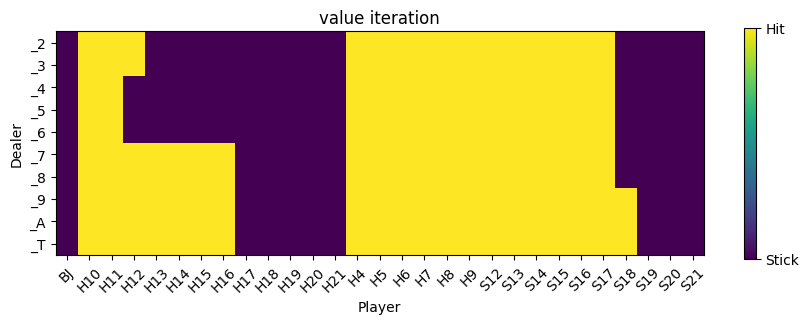

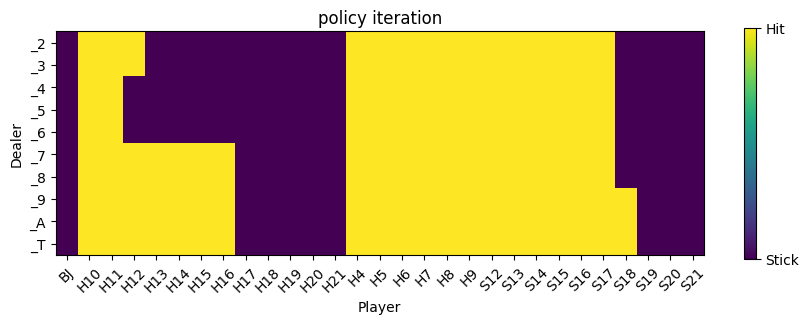

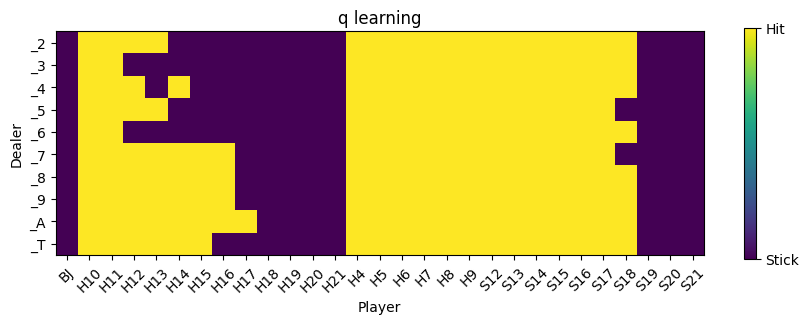

In [10]:
def get_state_action_matrix(pi):
    pi_df = pd.DataFrame(list(pi.items()), columns=['state', 'action'])
    pi_df['dealer_s'] = pi_df['state'] % 10
    pi_df['dealer_s'] = pi_df['dealer_s'].map(dealer_map)
    pi_df['player_s'] = pi_df['state'] // 10
    pi_df['player_s'] = pi_df['player_s'].map(player_map)
    pi_df['action'] = pi_df['action'].map(action_map)
    pi_df = pi_df.pivot(columns='player_s', index='dealer_s', values='action')
    return pi_df

def plot_state_action_matrix(pi, title):
    label_mapping = {'Stick': 0, 'Hit': 1}
    data_numeric = np.vectorize(label_mapping.get)(pi)

    plt.figure(figsize=(12, 3))
    plt.subplots_adjust(right=0.8)  # Adjust layout to make room for color bar
    plt.imshow(data_numeric, cmap='viridis', interpolation='nearest')
    plt.xticks(np.arange(pi.shape[1]), pi.columns, rotation=45)
    plt.yticks(np.arange(pi.shape[0]), pi.index)

    cbar = plt.colorbar(ticks=np.arange(len(label_mapping)))
    cbar.set_ticklabels(label_mapping.keys())

    plt.xlabel('Player')
    plt.ylabel('Dealer')

    plt.title(title)
    plt.grid(False)
    plt.show()


plot_pi_vi = get_state_action_matrix(pi_vi)
plot_state_action_matrix(plot_pi_vi, 'value iteration')

plot_pi_pi = get_state_action_matrix(pi_pi)
plot_state_action_matrix(plot_pi_pi, 'policy iteration')

plot_pi_q = get_state_action_matrix(pi_q)
plot_state_action_matrix(plot_pi_q, 'q learning')